### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

### Load Data & Model

In [2]:
df_train = pd.read_csv('../data/processed/train_data.csv')
model = joblib.load('../models/pricing_model.pkl')

print("Model & Data Loaded")
print(f"Features expected of the model: {model.n_features_in_}")

Model & Data Loaded
Features expected of the model: 40


### Optimization Function

In [3]:
def optimize_price(row_data, model, price_range_pct=0.20):
  """
  Finding the optimal price for a specific product.
  """
  current_price = row_data['unit_price']

  # Create a simulated price range (+/- 20% of the current price)
  test_price = np.linspace(current_price * (1 - price_range_pct), 
                           current_price * (1 + price_range_pct), 
                           num=50)
  
  revenues = []
  quantities = []

  feature_names = model.feature_names_in_

  for p in test_price:
    simulated_row = row_data.copy()
    simulated_row['unit_price'] = p

    simulated_row['diff_comp_1'] = p - simulated_row['comp_1']
    simulated_row['ratio_comp_1'] = p / simulated_row['comp_1']
    simulated_row['diff_comp_2'] = p - simulated_row['comp_2']
    simulated_row['ratio_comp_2'] = p / simulated_row['comp_2']
    simulated_row['diff_comp_3'] = p - simulated_row['comp_3']
    simulated_row['ratio_comp_3'] = p / simulated_row['comp_3']
    simulated_row['total_cost'] = p + simulated_row['freight_price']

    input_df = pd.DataFrame([simulated_row])

    input_df = input_df[feature_names]

    pred_qty = model.predict(input_df)[0]

    pred_qty = max(0, pred_qty)

    predicted_revenue = p * pred_qty

    revenues.append(predicted_revenue)
    quantities.append(pred_qty)

  max_rev_index = np.argmax(revenues)
  optimal_price = test_price[max_rev_index]
  max_revenue = revenues[max_rev_index]
  expected_qty = quantities[max_rev_index]

  return test_price, revenues, quantities, optimal_price, max_revenue, expected_qty

### Test Case: Take 1 Product at Random

In [4]:
# We take products whose original quantity is > 10
try:
  sample_product = df_train[df_train['qty'] > 10].sample(1, random_state=42).iloc[0]
except:
  sample_product = df_train.sample(1).iloc[0]

print(f"Product Sample ID (Encoded): {sample_product.name}")

prices, revenues, qtys, opt_price, max_rev, opt_qty = optimize_price(sample_product, model)

Product Sample ID (Encoded): 470


### Visualization of Results

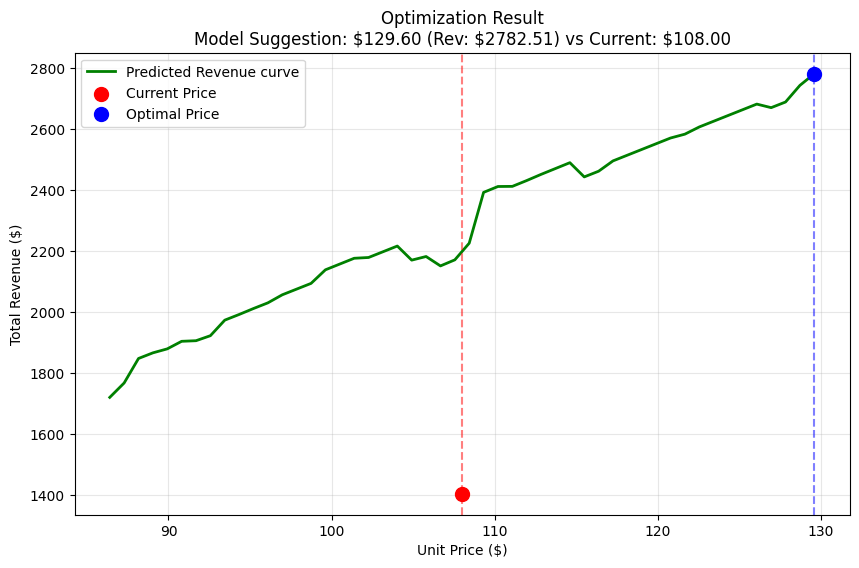

In [6]:
current_revenue = sample_product['unit_price'] * sample_product['qty']

plt.figure(figsize=(10, 6))
# Revenue Curve Plot (Green)
plt.plot(prices, revenues, label='Predicted Revenue curve', color='green', linewidth=2)

# Current Price Point (Red)
plt.scatter([sample_product['unit_price']], [current_revenue], color='red', s=100, label='Current Price', zorder=5)
plt.axvline(sample_product['unit_price'], color='red', linestyle='--', alpha=0.5)

# Optimal Price Point (Blue)
plt.scatter([opt_price], [max_rev], color='blue', s=100, label='Optimal Price', zorder=5)
plt.axvline(opt_price, color='blue', linestyle='--', alpha=0.5)

plt.title(f"Optimization Result\nModel Suggestion: ${opt_price:.2f} (Rev: ${max_rev:.2f}) vs Current: ${sample_product['unit_price']:.2f}")
plt.xlabel('Unit Price ($)')
plt.ylabel('Total Revenue ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Summary Text
print(f"\n--- MODEL RECOMMENDATION REPORT ---")
print(f"Current Price  : ${sample_product['unit_price']:.2f}")
print(f"Recommended Price: ${opt_price:.2f}")
diff = max_rev - current_revenue
print(f"Potential Increase : ${diff:.2f} ({((max_rev - current_revenue)/current_revenue)*100:.1f}%)")

if opt_price > sample_product['unit_price']:
    print("STRATEGY: RAISE PRICES (The market is willing to pay more)")
elif opt_price < sample_product['unit_price']:
    print("STRATEGY: DISCOUNTS/PRICE REDUCTIONS (Pursue sales volume)")
else:
    print("STRATEGY: HOLD PRICE (Already optimal)")


--- MODEL RECOMMENDATION REPORT ---
Current Price  : $108.00
Recommended Price: $129.60
Potential Increase : $1378.51 (98.2%)
STRATEGY: RAISE PRICES (The market is willing to pay more)


## Optimization Result Analysis: The "Undervalued" Asset

### 1. Diagnosis: Severe Underpricing
The simulation reveals a rare **Monotonic Positive Trend**.
* **Current State:** The product is priced at **$108.00** (Red Dot), generating ~$1,400 revenue.
* **AI Projection:** The model identifies strong pricing power, suggesting a price hike to **$129.60** (Blue Dot).
* **Projected Impact:** A massive **+98.2% Revenue Uplift**.

### 2. Economic Interpretation (Inelastic Demand)
The upward slope indicates that demand for this specific SKU is **Price Inelastic** within the tested range. Customers are relatively insensitive to price increases for this item. This could be driven by:
* **Lack of Competition:** The `diff_comp` features likely show we are still significantly cheaper than competitors even at $129.
* **Brand Loyalty/Necessity:** The product nature compels purchase regardless of slight price variance.

### 3. Strategic Recommendation (A/B Testing)
While the model suggests an aggressive 20% price hike, a "Big Bang" implementation is risky.
* **Action Plan:** Implement a **Phased Price Increase**.
* **Phase 1:** Increase price by 5% ($108 -> $113). Monitor churn.
* **Phase 2:** If volume remains stable, proceed towards the target of $129.